In [1]:
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import tifffile

In [2]:
image_dir = 'C:/Users/ziade/source/repos/Satellite_Data/images'
mask_dir = 'C:/Users/ziade/source/repos/Satellite_Data/labels'

image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))
mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))

print("Image Paths:", image_paths[:5])
print("Mask Paths:", mask_paths[:5])

from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.15, random_state=42)

train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    train_image_paths, train_mask_paths, test_size=0.21, random_state=42)

batch_size = 16

Image Paths: ['C:/Users/ziade/source/repos/Satellite_Data/images\\0.tif', 'C:/Users/ziade/source/repos/Satellite_Data/images\\1.tif', 'C:/Users/ziade/source/repos/Satellite_Data/images\\10.tif', 'C:/Users/ziade/source/repos/Satellite_Data/images\\100.tif', 'C:/Users/ziade/source/repos/Satellite_Data/images\\101.tif']
Mask Paths: ['C:/Users/ziade/source/repos/Satellite_Data/labels\\0.png', 'C:/Users/ziade/source/repos/Satellite_Data/labels\\1.png', 'C:/Users/ziade/source/repos/Satellite_Data/labels\\10.png', 'C:/Users/ziade/source/repos/Satellite_Data/labels\\100.png', 'C:/Users/ziade/source/repos/Satellite_Data/labels\\101.png']


In [3]:
class SatelliteDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = self.load_image(self.image_paths[idx])
        mask = self.load_mask(self.mask_paths[idx])
        
        if self.transform:
            image, mask = self.transform(image, mask)
        
        return image, mask

    def load_image(self, image_path):
        image = np.array(tifffile.imread(image_path), dtype=np.float32)
        image = torch.tensor(image).float().permute(2, 0, 1)  # Convert HWC to CHW
        return image
    
    def load_mask(self, mask_path):
        mask = Image.open(mask_path).convert('L')
        mask = np.expand_dims(mask, axis=-1).astype(np.float32)
        mask = torch.tensor(mask).float().permute(2, 0, 1)  # Convert HWC to CHW
        return mask
    
def normalize_image(image):
        normalized_image = np.zeros([12,128,128])
        for j in range(12):
            min_val = np.min(image[j])
            max_val = np.max(image[j])
            normalized_image[j] = (image[j] - min_val) / (max_val - min_val) if max_val - min_val > 1 else image[j] - min_val
        return normalized_image
    
class RandomHorizontalFlip:
    def __call__(self, image, mask):
        if torch.rand(1) < 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)
        return image, mask

class RandomVerticalFlip:
    def __call__(self, image, mask):
        if torch.rand(1) < 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)
        return image, mask

class RandomBrightness:
    def __call__(self, image):
        image_np = image.numpy().astype(np.float32)
        brightness_factor = np.random.uniform(0.8, 1.2)
        image_np = np.clip(image_np * brightness_factor, 0, 1)
        return image

class RandomContrast:
    def __call__(self, image):
        image_np = image.numpy().astype(np.float32)
        mean = np.mean(image_np, axis=(1, 2), keepdims=True)
        contrast_factor = np.random.uniform(0.8, 1.2)
        image_np = np.clip((image_np - mean) * contrast_factor + mean, 0, 1)
        return image
    
class ToTensorAndAugment:
    def __init__(self):
        self.horizontal_flip = RandomHorizontalFlip()
        self.vertical_flip = RandomVerticalFlip()
        self.brightness = RandomBrightness()
        self.contrast = RandomContrast()

    def __call__(self, image, mask):
        image, mask = self.horizontal_flip(image, mask)
        image, mask = self.vertical_flip(image, mask)
        image = self.brightness(image)
        image = self.contrast(image)
        
        image = image.clone().detach()
        mask = mask.clone().detach()
        
        return image, mask
    
train_dataset = SatelliteDataset(train_image_paths, train_mask_paths, transform=ToTensorAndAugment())
val_dataset = SatelliteDataset(val_image_paths, val_mask_paths)
test_dataset = SatelliteDataset(test_image_paths, test_mask_paths)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [4]:
channel_names = ['Coastal aerosol', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA BAND', 'Merit DEM', 'Copernicus DEM', 'ESA world cover map', 'Water occurrence probability']

first_image_shape = None
consistent_shape = True

batch_images, batch_masks = next(iter(test_loader))
ind = np.random.randint(low=0, high=batch_images.shape[0])
display = normalize_image(batch_images[ind].cpu().numpy())
disp_mask = batch_masks[ind]
for i in range(len(batch_images)):
    if first_image_shape is None:
        first_image_shape = batch_images[i].shape
    else:
        if batch_images[i].shape != first_image_shape:
            print(f"Mismatch found: {batch_images[i].shape} != {first_image_shape}")
            consistent_shape = False
            break
print("Shape of batch_images:", batch_images.shape, "and len: ", len(batch_images))
print("Shape of batch_masks:", batch_masks.shape)
if consistent_shape:
    print(f"All images have the same shape: {first_image_shape}")
    input_shape = first_image_shape
else:
    print("Not all images have the same shape.")

Shape of batch_images: torch.Size([16, 12, 128, 128]) and len:  16
Shape of batch_masks: torch.Size([16, 1, 128, 128])
All images have the same shape: torch.Size([12, 128, 128])


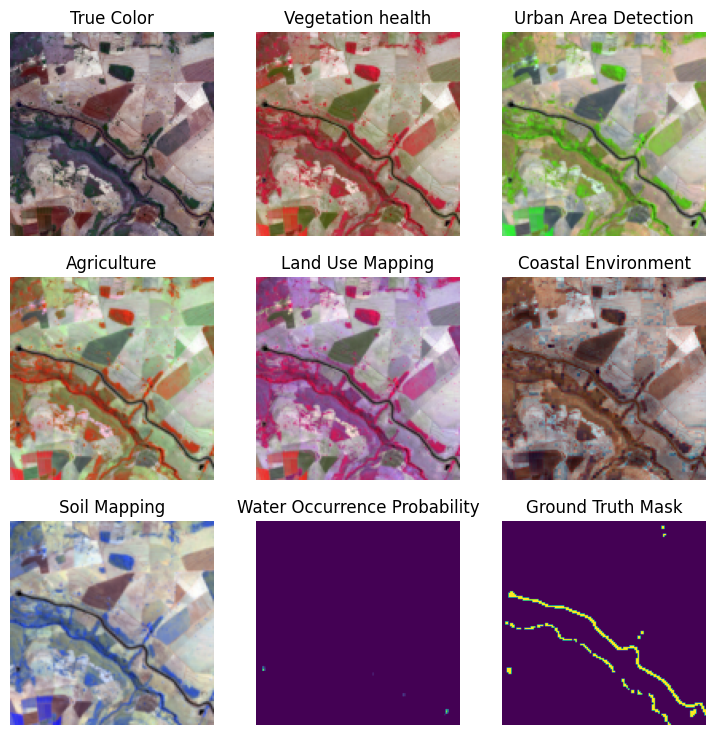

In [5]:
true_color = np.stack([display[channel_names.index('Red')],
                       display[channel_names.index('Green')],
                       display[channel_names.index('Blue')]], axis=-1)
false_color_vegetation = np.stack([display[channel_names.index('NIR')],
                                   display[channel_names.index('Red')],
                                   display[channel_names.index('Green')]], axis=-1)
urban_detection = np.stack([display[channel_names.index('SWIR1')],
                            display[channel_names.index('NIR')],
                            display[channel_names.index('Red')]], axis=-1)
water_detection = display[channel_names.index('Water occurrence probability')]
agriculture_composite = np.stack([display[channel_names.index('NIR')],
                           display[channel_names.index('SWIR2')],
                           display[channel_names.index('Red')]], axis=-1)
coastal_composite = np.stack([display[channel_names.index('Coastal aerosol')],
                              display[channel_names.index('Blue')],
                              display[channel_names.index('Green')]], axis=-1)
geology_composite = np.stack([display[channel_names.index('SWIR2')],
                              display[channel_names.index('SWIR1')],
                              display[channel_names.index('NIR')]], axis=-1)
landuse_composite = np.stack([display[channel_names.index('NIR')],
                              display[channel_names.index('Red')],
                              display[channel_names.index('SWIR1')]], axis=-1)

vis = {"True Color": true_color, "Vegetation health": false_color_vegetation, "Urban Area Detection": urban_detection, "Agriculture": agriculture_composite, "Land Use Mapping": landuse_composite,
       "Coastal Environment": coastal_composite, "Soil Mapping": geology_composite, "Water Occurrence Probability": water_detection, "Ground Truth Mask": disp_mask[0]}

plt.figure(figsize=(len(vis), len(vis)))
index = 1
for name in vis:
    ax = plt.subplot(3, 3, index)
    plt.imshow(vis[name])
    plt.title(name)
    plt.axis("off")
    index += 1

In [6]:
import torchvision.models.segmentation as segmentation
class DeepLab(nn.Module):
    def __init__(self):
        super(DeepLab, self).__init__()
        self.model = segmentation.deeplabv3_resnet50(pretrained=True, progress=True)
        
        self.model.backbone.conv1 = nn.Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        self.model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1))

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.backbone.conv1.parameters():
            param.requires_grad = True
        for param in self.model.classifier[4].parameters():
            param.requires_grad = True

    def forward(self, x):
        output = self.model(x)['out']
        output = torch.sigmoid(output)
        return output
    
    def unfreeze_classifier(self):
        for param in self.model.classifier.parameters():
            param.requires_grad = True

    def unfreeze_all(self):
        for param in self.model.parameters():
            param.requires_grad = True

In [7]:
from segmentation_models_pytorch import Unet
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.model = Unet(
            encoder_name='resnet34', 
            encoder_weights='imagenet', 
            in_channels=12,
            classes=1,
        )
        
        self.batch_norm = nn.BatchNorm2d(12)

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.encoder.conv1.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.batch_norm(x)
        output = self.model(x)
        return torch.sigmoid(output)

    def unfreeze_classifier(self):
        for param in self.model.segmentation_head.parameters():
            param.requires_grad = True

    def unfreeze_all(self):
        for param in self.model.parameters():
            param.requires_grad = True

In [8]:
import torch.nn.functional as F
    
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):

        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        F_loss = F_loss.mean()

        inputs = inputs.squeeze(1)
        targets = targets.float().squeeze(1)

        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        dice = 1 - dice
        return F_loss + dice
    
class BCE(nn.Module):
    def __init__(self, reduction='mean'):
        super(BCE, self).__init__()
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction=self.reduction)
        return BCE_loss
    
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_iou(preds, targets):
    intersection = ((preds == 1) & (targets == 1)).sum().item()
    union = ((preds == 1) | (targets == 1)).sum().item()
    iou = intersection / (union + 1e-6)
    return iou

In [9]:
import torch.optim as optim
from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
print(summary(model, input_size=(batch_size, 12, 128, 128)))

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=4e-3, weight_decay=3e-4)  #to be adjusted
criterion = CombinedLoss()

def train_or_evaluate(model, dataloader, optimizer=optimizer, loss_fn=criterion, device=device, mode='train'):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    
    total_loss = 0.0
    all_accuracies = []
    all_precisions = []
    all_recalls = []
    all_f1s = []
    all_ious = []
    
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        
        if mode == 'train':
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                outputs = model(images)
                loss = loss_fn(outputs, masks)
        
        total_loss += loss.item()

        preds = (outputs > 0.5).float()

        accuracy = accuracy_score(masks.view(-1).cpu().numpy(), preds.view(-1).cpu().numpy())
        precision = precision_score(masks.view(-1).cpu().numpy(), preds.view(-1).cpu().numpy(), average='weighted')
        recall = recall_score(masks.view(-1).cpu().numpy(), preds.view(-1).cpu().numpy(), average='weighted')
        f1 = f1_score(masks.view(-1).cpu().numpy(), preds.view(-1).cpu().numpy(), average='weighted')
        iou = calculate_iou(preds, masks)
        
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)
        all_ious.append(iou)
    
    average_loss = total_loss / len(dataloader)
    average_accuracy = sum(all_accuracies) / len(all_accuracies) if all_accuracies else 0.0
    average_precision = sum(all_precisions) / len(all_precisions) if all_precisions else 0.0
    average_recall = sum(all_recalls) / len(all_recalls) if all_recalls else 0.0
    average_f1 = sum(all_f1s) / len(all_f1s) if all_f1s else 0.0
    average_iou = sum(all_ious) / len(all_ious) if all_ious else 0.0
    
    return average_loss, average_accuracy, average_precision, average_recall, average_f1, average_iou

Layer (type:depth-idx)                             Output Shape              Param #
UNet                                               [16, 1, 128, 128]         --
├─BatchNorm2d: 1-1                                 [16, 12, 128, 128]        24
├─Unet: 1-2                                        [16, 1, 128, 128]         --
│    └─ResNetEncoder: 2-1                          [16, 12, 128, 128]        --
│    │    └─Conv2d: 3-1                            [16, 64, 64, 64]          37,632
│    │    └─BatchNorm2d: 3-2                       [16, 64, 64, 64]          (128)
│    │    └─ReLU: 3-3                              [16, 64, 64, 64]          --
│    │    └─MaxPool2d: 3-4                         [16, 64, 32, 32]          --
│    │    └─Sequential: 3-5                        [16, 64, 32, 32]          (221,952)
│    │    └─Sequential: 3-6                        [16, 128, 16, 16]         (1,116,416)
│    │    └─Sequential: 3-7                        [16, 256, 8, 8]           (6,822,400)
│  

In [10]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []
train_ious, val_ious = [], []

model.unfreeze_classifier()
num_epochs1 = 100
count = 0

for epoch in range(num_epochs1):
    train_loss, train_accuracy, train_precision, train_recall, train_f1, train_iou = train_or_evaluate(model, train_loader, mode='train')
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_iou = train_or_evaluate(model, val_loader, mode='eval')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_precisions.append(train_precision)
    val_precisions.append(val_precision)
    train_recalls.append(train_recall)
    val_recalls.append(val_recall)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    count += 1
    print(f'Epoch {epoch+1}/{num_epochs1}')
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}')

Epoch 1/100
Train Loss: 0.7117, Accuracy: 0.3278, Precision: 0.6970, Recall: 0.3278, F1: 0.2552, IoU: 0.2726
Val Loss: 0.6554, Accuracy: 0.3708, Precision: 0.7187, Recall: 0.3708, F1: 0.2984, IoU: 0.3153
Epoch 2/100
Train Loss: 0.6904, Accuracy: 0.3360, Precision: 0.7214, Recall: 0.3360, F1: 0.2654, IoU: 0.2777
Val Loss: 0.6427, Accuracy: 0.3748, Precision: 0.7250, Recall: 0.3748, F1: 0.3051, IoU: 0.3168
Epoch 3/100
Train Loss: 0.6819, Accuracy: 0.3385, Precision: 0.7211, Recall: 0.3385, F1: 0.2688, IoU: 0.2780
Val Loss: 0.6393, Accuracy: 0.3790, Precision: 0.7278, Recall: 0.3790, F1: 0.3123, IoU: 0.3179
Epoch 4/100
Train Loss: 0.6730, Accuracy: 0.3468, Precision: 0.7333, Recall: 0.3468, F1: 0.2797, IoU: 0.2834
Val Loss: 0.6352, Accuracy: 0.3797, Precision: 0.7258, Recall: 0.3797, F1: 0.3143, IoU: 0.3177
Epoch 5/100
Train Loss: 0.6698, Accuracy: 0.3482, Precision: 0.7376, Recall: 0.3482, F1: 0.2828, IoU: 0.2825
Val Loss: 0.6332, Accuracy: 0.3818, Precision: 0.7307, Recall: 0.3818, F1: 

In [11]:
model.unfreeze_all()
num_epochs2 = 100
optimizer = optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)  #to be adjusted

for epoch in range(num_epochs2):
    train_loss, train_accuracy, train_precision, train_recall, train_f1, train_iou = train_or_evaluate(model, train_loader, optimizer=optimizer, mode='train')
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_iou = train_or_evaluate(model, val_loader, mode='eval')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_precisions.append(train_precision)
    val_precisions.append(val_precision)
    train_recalls.append(train_recall)
    val_recalls.append(val_recall)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    count += 1
    print(f'Epoch {epoch+1}/{num_epochs2}')
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}')

Epoch 1/100
Train Loss: 0.4841, Accuracy: 0.7783, Precision: 0.8553, Recall: 0.7783, F1: 0.7820, IoU: 0.5298
Val Loss: 0.3532, Accuracy: 0.8947, Precision: 0.9036, Recall: 0.8947, F1: 0.8931, IoU: 0.6663
Epoch 2/100
Train Loss: 0.3904, Accuracy: 0.8735, Precision: 0.8891, Recall: 0.8735, F1: 0.8760, IoU: 0.5936
Val Loss: 0.3092, Accuracy: 0.8979, Precision: 0.9077, Recall: 0.8979, F1: 0.8956, IoU: 0.6710
Epoch 3/100
Train Loss: 0.3154, Accuracy: 0.8960, Precision: 0.9002, Recall: 0.8960, F1: 0.8932, IoU: 0.6475
Val Loss: 0.3069, Accuracy: 0.8918, Precision: 0.9051, Recall: 0.8918, F1: 0.8928, IoU: 0.6669
Epoch 4/100
Train Loss: 0.3164, Accuracy: 0.8953, Precision: 0.8963, Recall: 0.8953, F1: 0.8921, IoU: 0.6410
Val Loss: 0.2983, Accuracy: 0.8977, Precision: 0.9071, Recall: 0.8977, F1: 0.8976, IoU: 0.6788
Epoch 5/100
Train Loss: 0.3048, Accuracy: 0.8948, Precision: 0.8995, Recall: 0.8948, F1: 0.8939, IoU: 0.6573
Val Loss: 0.2794, Accuracy: 0.9070, Precision: 0.9133, Recall: 0.9070, F1: 

Epoch 1/200
Train Loss: 0.2174, Accuracy: 0.9139, Precision: 0.9140, Recall: 0.9139, F1: 0.9121, IoU: 0.7018
Val Loss: 0.1898, Accuracy: 0.9272, Precision: 0.9282, Recall: 0.9272, F1: 0.9262, IoU: 0.7550
Epoch 2/200
Train Loss: 0.2115, Accuracy: 0.9157, Precision: 0.9163, Recall: 0.9157, F1: 0.9136, IoU: 0.7048
Val Loss: 0.1868, Accuracy: 0.9282, Precision: 0.9290, Recall: 0.9282, F1: 0.9276, IoU: 0.7611
Epoch 3/200
Train Loss: 0.2000, Accuracy: 0.9186, Precision: 0.9181, Recall: 0.9186, F1: 0.9168, IoU: 0.7141
Val Loss: 0.1758, Accuracy: 0.9301, Precision: 0.9310, Recall: 0.9301, F1: 0.9297, IoU: 0.7702
Epoch 4/200
Train Loss: 0.2101, Accuracy: 0.9152, Precision: 0.9143, Recall: 0.9152, F1: 0.9138, IoU: 0.7144
Val Loss: 0.1766, Accuracy: 0.9306, Precision: 0.9315, Recall: 0.9306, F1: 0.9298, IoU: 0.7678
Epoch 5/200
Train Loss: 0.2071, Accuracy: 0.9163, Precision: 0.9160, Recall: 0.9163, F1: 0.9136, IoU: 0.6908
Val Loss: 0.1801, Accuracy: 0.9304, Precision: 0.9315, Recall: 0.9304, F1: 

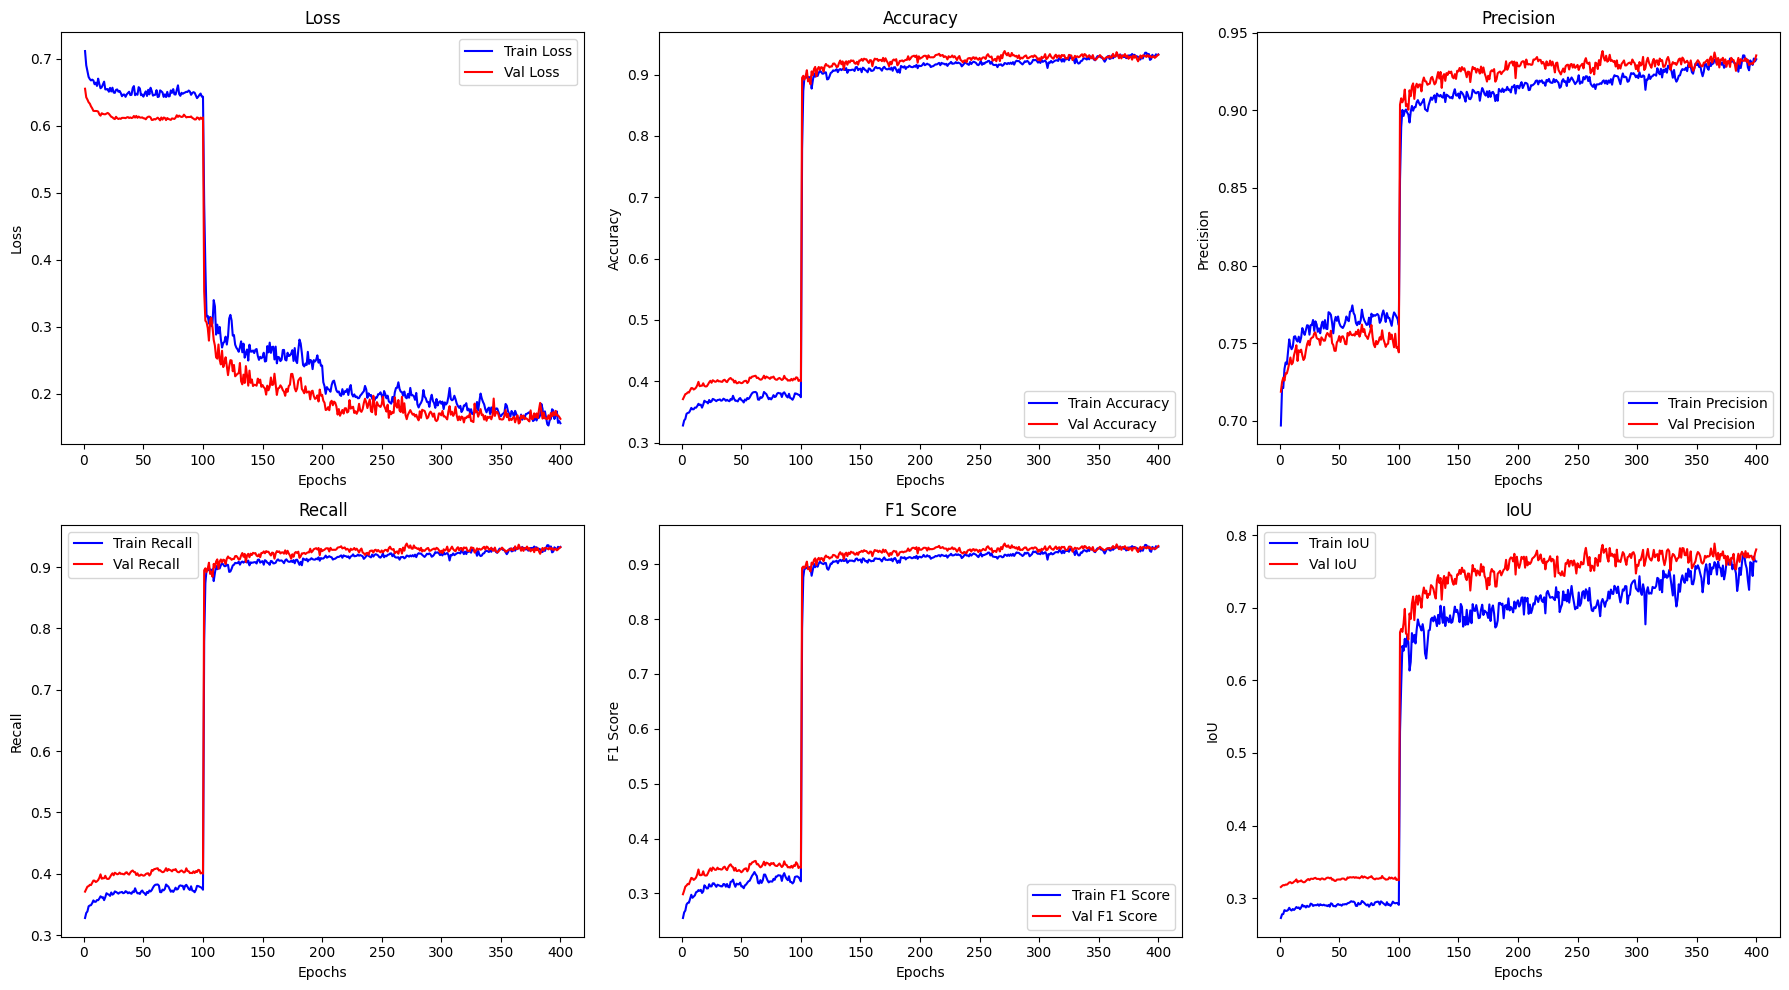

In [12]:
num_epochs3 = 200
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=3e-4)  #to be adjusted
criteriona = BCE()

for epoch in range(num_epochs3):
    train_loss, train_accuracy, train_precision, train_recall, train_f1, train_iou = train_or_evaluate(model, train_loader, optimizer=optimizer, loss_fn=criteriona, mode='train')
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_iou = train_or_evaluate(model, val_loader, loss_fn=criteriona, mode='eval')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_precisions.append(train_precision)
    val_precisions.append(val_precision)
    train_recalls.append(train_recall)
    val_recalls.append(val_recall)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    count += 1
    print(f'Epoch {epoch+1}/{num_epochs3}')
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}')

epochs = range(1, count + 1)

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, train_precisions, 'b', label='Train Precision')
plt.plot(epochs, val_precisions, 'r', label='Val Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, train_recalls, 'b', label='Train Recall')
plt.plot(epochs, val_recalls, 'r', label='Val Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, train_f1s, 'b', label='Train F1 Score')
plt.plot(epochs, val_f1s, 'r', label='Val F1 Score')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(epochs, train_ious, 'b', label='Train IoU')
plt.plot(epochs, val_ious, 'r', label='Val IoU')
plt.title('IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
loss, accuracy, precision, recall, f1, iou = train_or_evaluate(model, test_loader, loss_fn=criteriona, mode='eval')
print(f'Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, IoU: {iou:.4f}')

Test Loss: 0.1300, Accuracy: 0.9491, Precision: 0.9494, Recall: 0.9491, F1: 0.9492, IoU: 0.7745


In [14]:
torch.save(model.state_dict(), 'week4_task.pth')

In [10]:
model = UNet()
device = torch.device('cpu')
model.load_state_dict(torch.load('week4_task.pth', map_location=device))

C:\Users\ziade\AppData\Local\Temp\ipykernel_15200\1638988815.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('week4_task.pth', map_locat

<All keys matched successfully>

In [11]:
def plot_masks(image, ground_truth_mask, predicted_mask):
    
    image = normalize_image(image.cpu().numpy()).transpose(1, 2, 0)
    ground_truth_mask = ground_truth_mask.cpu().numpy().squeeze()
    predicted_mask = predicted_mask.cpu()
    predicted_mask = predicted_mask.detach().numpy().squeeze()

    rgb_image = image[:, :, 1:4]
    rgb_image = rgb_image[:, :, ::-1]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(ground_truth_mask, cmap='gray')
    axes[0].set_title('Ground Truth Mask')
    axes[0].axis('off')
    
    axes[1].imshow(predicted_mask > 0.5, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    overlay = rgb_image.copy()
    overlay[predicted_mask > 0.5, :] = [0, 0, 1]
    axes[2].imshow(overlay)
    axes[2].set_title('Overlaid Mask')
    axes[2].axis('off')
    
    plt.show()

In [50]:
def plot_masks_fake(image, ground_truth_mask, predicted_mask):
    
    #image = normalize_image(image.cpu().numpy()).transpose(1, 2, 0)
    image = image.cpu().numpy().transpose(1, 2, 0)
    ground_truth_mask = ground_truth_mask.cpu().numpy().squeeze()
    predicted_mask = predicted_mask.cpu()
    predicted_mask = predicted_mask.detach().numpy().squeeze()

    rgb_image = image[:, :, 1:4]
    rgb_image = rgb_image[:, :, ::-1]
    min_val = np.min(rgb_image)
    max_val = np.max(rgb_image)

    print(f"min_val: {min_val} \nmax_val: {max_val}")
    rgbn_image = np.zeros((128,128,3))
    """for j in range(3):  #if this is to be used then use [0...1] and 1 for mask overlay
            min_val = np.min(rgb_image[:, :, j])
            max_val = np.max(rgb_image[:, :, j])
            rgbn_image[:, :, j] = (rgb_image[:, :, j] - min_val) / (max_val - min_val) if max_val - min_val > 1 else rgb_image[:, :, j] - min_val
    for j in range(3):
        min_val = np.min(rgb_image[:, :, j])
        max_val = np.max(rgb_image[:, :, j])
        rgbn_image[:, :, j] = rgb_image[:, :, j] * 255 / (max_val - min_val)"""
    rgbn_image = rgb_image * 255 / (np.max(rgb_image) - np.min(rgb_image))
    rgbn_image = rgbn_image.astype(np.uint8)
    print(f"now \nmin_val: {np.min(rgbn_image)} \nmax_val: {np.max(rgbn_image)}")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(ground_truth_mask, cmap='gray')
    axes[0].set_title('Ground Truth Mask')
    axes[0].axis('off')
    
    axes[1].imshow(predicted_mask > 0.5, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    overlay = rgbn_image.copy()
    overlay[predicted_mask > 0.5, :] = [0, 0, 255]
    axes[2].imshow(overlay)
    axes[2].set_title('Overlaid Mask')
    axes[2].axis('off')
    
    plt.show()

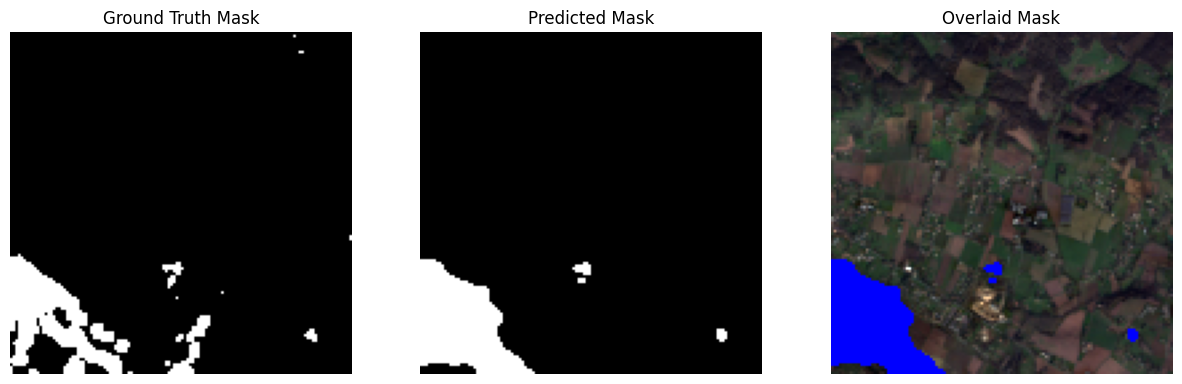

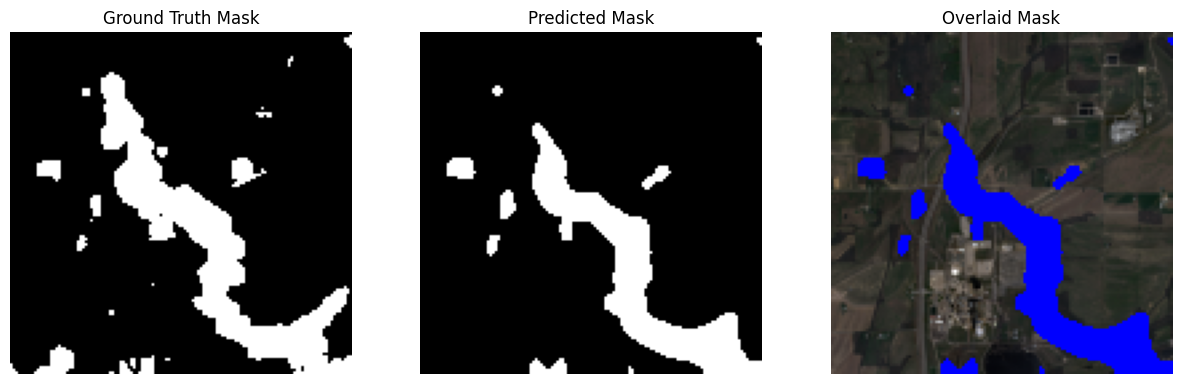

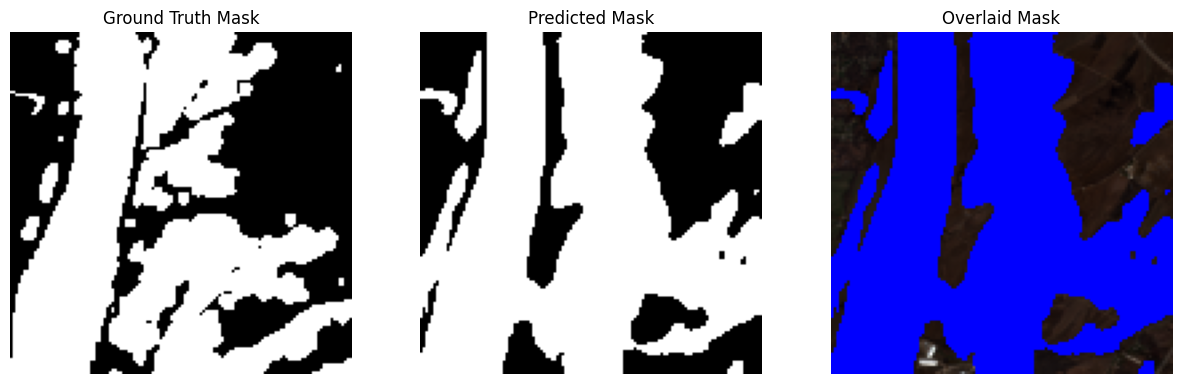

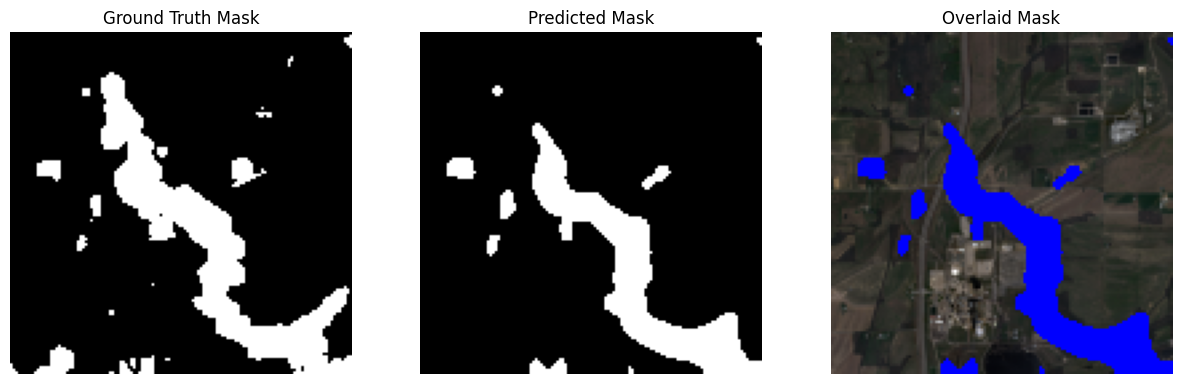

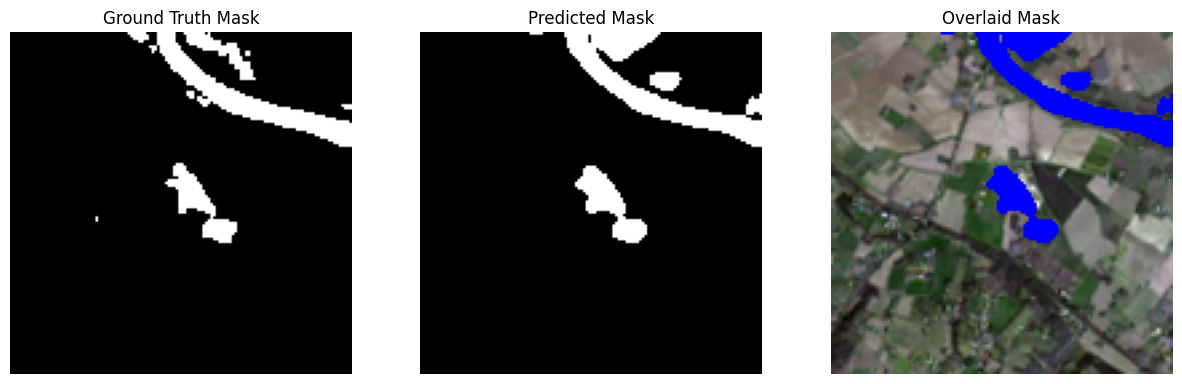

In [13]:
batch_images, batch_masks = next(iter(test_loader))
disp_preds = model(batch_images.to(device))
for _ in range(5):
    ind = np.random.randint(low=0, high=batch_images.shape[0])
    display = batch_images[ind]
    disp_mask = batch_masks[ind]
    disp_pred = disp_preds[ind]
    
    plot_masks(display, disp_mask, disp_pred)